In [119]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS, FeatureHasher
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

from matplotlib import pyplot as plt
import seaborn as sns

In [120]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [121]:
ep = pd.read_csv('ep_desc.csv', index_col=0)
ep.shape

(176, 4)

In [122]:
scriptnum = list(range(102,278))
ep['scriptnum'] = scriptnum

In [123]:
ep.sample(1)

,season,ep,title,summary,scriptnum
19,4,20,Qpid,"Q is back, as is Vash (of “The Captain’s Holi...",194


In [124]:
#import scripts broken down in to dialog chunks
df = pd.read_csv('tng_scripts.csv', index_col=0)
df.shape

(174, 5)

In [125]:
df.sample(5)

,episode,script,len_char,len_words,season
143,247,\n\n\n\n\n\n\n STAR TREK: THE N...,76882,3384,6
105,207,\n\n\n\n\n STAR TREK: THE NEXT ...,64402,3049,5
37,139,\n\n\n\n\n STAR TREK: THE NEXT ...,62143,3085,2
102,204,\n\n\n\n\n\n\n\n STAR TREK: THE...,66026,2956,5
129,233,\n\n\n\n\n\n\n STAR TREK: THE N...,71893,3150,6


### Topic Modeling with CountVectorizer and TruncatedSVD

In [129]:
stop_words = ENGLISH_STOP_WORDS.union("star", "trek", "tng")

countv = CountVectorizer(stop_words = stop_words, ngram_range=(1,4))

In [130]:
doc_word = countv.fit_transform(df['script'])
doc_word.shape

(174, 1835529)

In [131]:
model = TruncatedSVD(n_components = 5)

In [132]:
doc_topic_matrix = model.fit_transform(doc_word)
doc_topic_matrix.shape

(174, 5)

In [133]:
doc_topic_matrix_df = pd.DataFrame(doc_topic_matrix).add_prefix('topic_')

columns_to_copy = ['episode', 'season']
doc_topic_matrix_df[columns_to_copy] = df[columns_to_copy]

doc_topic_matrix_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,episode,season
0,527.957922,93.042874,199.428184,-144.573798,-125.247644,102,1
1,346.567323,-11.052708,6.888561,-78.741172,-0.991007,103,1
2,305.269102,85.702864,14.088841,-82.334376,-8.279060,104,1
3,23.195435,1.491108,-2.688621,-5.287994,-3.330778,105,1
4,321.101274,102.534267,68.751070,-58.264302,-15.019280,106,1


In [134]:
model.n_components

5

In [135]:
model.explained_variance_

array([9828.52356308, 6943.94197287, 6554.80534499, 5333.54357066,
       4134.89943266])

In [136]:
model.explained_variance_ratio_

array([0.07034929, 0.04970242, 0.04691711, 0.03817572, 0.02959623])

In [137]:
def top_scripts(doc_topic_matrix, topic, num):
    return (doc_topic_matrix
            .sort_values(by=topic, ascending=False)
                .head(num)['episode']
            .values)

def top_words(doc_topic_matrix, topic, num):
    return (doc_topic_matrix
            .sort_values(by=topic, ascending=False)
            .head(num))[topic]

In [138]:
display_topics(model, countv.get_feature_names(), 10)


Topic  0
picard, riker, data, star, trek, star trek, act, worf, geordi, continued

Topic  1
picard, captain, vash, ro, continued picard, jameson, jason, wesley, 87, tasha

Topic  2
riker, lieutenant, troi, pulaski, soren, lt, lt riker, 89, lieutenant riker, 89 act

Topic  3
worf, klingon, alexander, kahless, beat, act, gowron, trek, star trek, star

Topic  4
geordi, beverly, barclay, troi, 92, 92 act, beat, 11, star, star trek


In [111]:
tpscripts = top_scripts(doc_topic_matrix_df, 'topic_0', 5)
tpscripts

array([102, 148, 251, 250, 182])

In [112]:
ep[ep.scriptnum.isin(tpscripts)]

,season,ep,title,summary,scriptnum
0,1,1-2,Encounter at Farpoint,Essentially everything and everyone in the ne...,102
22,2,22,Shades of Gray,A clip show about which we will never speak a...,148
7,4,8,Future Imperfect,Commander Riker’s head trip: Sixteen years in...,182
0,6,24,Second Chances,Season 6 of The Next Generation may definitel...,250
0,6,25,Timescape,An away mission finds itself in an area of sp...,251


In [113]:
top_words(doc_topic_matrix_df, 'topic_0', 10)

0      527.957922
46     429.653144
147    407.129650
146    401.025452
80     394.327054
86     394.027273
78     392.948918
154    387.908086
64     382.104264
83     379.028199
Name: topic_0, dtype: float64

In [114]:
doc_topic.dot(doc_topic[4])

array([203090.38803191, 115224.14580527, 112700.78018282,   7774.64855516,
       121970.58933432,  48834.71090147, 119297.58719468, 106595.4254282 ,
       143216.80716343, 104585.78765578, 114550.87635452,  81554.7979944 ,
       102156.35803568,  23157.00594367,  72995.88624863,  88569.99331774,
        94535.87732384,  92502.74318695,  90992.52223615,  99442.65845201,
        90034.61379506,   4323.64648842, 123522.93557208, 120764.74586208,
         2137.67788298, 106003.80607838, 123346.85512922,  74078.21825102,
         8486.12393926,    328.27573281, 102786.75194852,  98219.67164361,
        71555.01472636,  99231.71700254,  20369.40890176, 113449.35834048,
        77922.5610421 , 128688.38473893,  84633.10995965, 105190.46863679,
       103935.24405412, 110347.01982097,  98310.36065252, 126903.66989607,
        81317.70549197, 106031.02641737, 143312.06361783,  91271.01774286,
        98835.93055989, 118462.35969958, 104426.22122077,  99749.33060072,
       104042.33239328,  

### MNF Model with CounterVectorizer

In [115]:
nmf_model = NMF(n_components = 10)
doc_topic = nmf_model.fit_transform(doc_word)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [116]:
display_topics(nmf_model, countv.get_feature_names(), 20)


Topic  0
data, geordi, star, trek, star trek, act, continued, rev, 10, continuing, 93, lore, worf, doctor, int, beat, 93 act, continued data, juliana, soong

Topic  1
picard, star, trek, star trek, act, continued, rev, captain, beat, riker, ro, 91, int, 91 act, ship, don, vash, looks, room, continued picard

Topic  2
riker, star trek, trek, act, star, troi, continued, lieutenant, data, commander, rev, 93, beverly, soren, beat, looks, doctor, 93 act, int, lt

Topic  3
worf, star trek, trek, star, act, klingon, continued, alexander, kahless, beat, gowron, rev, looks, mtar, ehleyr, kurn, father, 10, moment, int

Topic  4
geordi, star, star trek, trek, act, riker, picard, rev, int, continued, data, optical, beat, 92, aquiel, scott, worf, ship, enterprise, 92 act

Topic  5
troi, lwaxana, star, star trek, trek, act, clara, continued, picard, mother, rev, int, alkar, mrs troi, mrs, 92, maques, dark, looks, don

Topic  6
beverly, star, star trek, trek, act, wesley, continued, picard, beat, 11

# Tfidf with NMD

In [607]:
#tfidf = TfidfVectorizer(ngram_range=(1,3), max_df=0.75, min_df=0.1)
tfidf = TfidfVectorizer(ngram_range=(1,3),  stop_words = 'english')

doc_word = tfidf.fit_transform(df['script'])
doc_word.shape

(174, 1105402)

In [141]:
nmf_model =  NMF(n_components=20)

In [144]:
doc_topic = nmf_model.fit_transform(doc_word)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [145]:
doc_topic_df = pd.DataFrame(doc_topic).add_prefix('topic_')


In [ ]:
doc_topic_df

In [542]:
display_topics(nmf_model, countv.get_feature_names(), 20)


Topic  0
loud pistol, of passive resistance, riker crouches, staff to, column in, 89 include, 8a continued throws, puppies dozen, purposely leaving, see to your, acre plot of, 90e int, around disappointed, picard pack his, be kidding joval, 90e, camera on his, half away discarding, factly turns to, avoid bonding in

Topic  1
a4, a3, since the enterprise, loud pistol, indelicate but pause, puppies dozen, see to your, purposely leaving, selecting the planet, column in, acre plot of, around disappointed, of passive resistance, of enjoyment involved, factly turns to, satie it must, have minute geordi, knows it his, still dead to, of falling over

Topic  2
annoyed at this, it is round, factly turns to, noble in reason, geordi moves after, pursued in good, seeing his, seeing himself in, geordi not bad, klingon medicine refers, klingon memories, seeing picard, seeing patient in, pursuing riker no, noble in, seeds isabella can, pursue relationships, seeds isabella tired, must resort, geordi m

In [139]:
kmeans = KMeans(n_clusters=5)

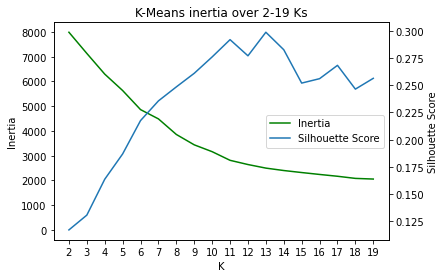

In [140]:
### Write code here
output = []
sill = []

from sklearn.metrics import silhouette_score

for i in range(2,20):
    model = KMeans(n_clusters=i)
    model.fit(doc_topic)
    output.append(model.inertia_)
    sill.append(silhouette_score(doc_topic, labels=model.labels_))

fig, ax = plt.subplots()
#plt.plot(range(2,11), output)
l1, = ax.plot(range(2,20), output, linestyle='-', color='green')
ax.vlines(x=12, ymin=0, ymax=10, color='red', linestyle='--')
ax2 = ax.twinx()
l2, = ax2.plot(range(2,20), sill)
plt.xticks(range(2,20));
plt.title('K-Means inertia over 2-19 Ks')
ax.set_xlabel('K')
ax.set_ylabel('Inertia')
ax2.set_ylabel('Silhouette Score')
plt.legend(handles = [l1, l2],
           labels = ['Inertia', 'Silhouette Score'],
           loc='center right')
fig.savefig('plottemp.jpg')